In [1]:
from tqdm import tqdm
import json
import pandas as pd
from pathlib import Path
import numpy as np

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt  

2025-06-16 17:51:00.790179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750085460.801397   32791 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750085460.804710   32791 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750085460.814240   32791 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750085460.814252   32791 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750085460.814253   32791 computation_placer.cc:177] computation placer alr

In [2]:
split_dir = Path('dataset') / 'scispacy_split'

In [3]:
X_train = np.load(split_dir / 'X_train.npy')
X_train_sent = np.load(split_dir / 'X_train_sent.npy')
X_test = np.load(split_dir / 'X_test.npy')
X_test_sent = np.load(split_dir / 'X_test_sent.npy')
y_train = np.load(split_dir / 'y_train.npy')
y_test = np.load(split_dir / 'y_test.npy')

len(X_train), len(X_test), len(y_train), len(y_test), len(X_train_sent), len(X_test_sent)

(400, 101, 400, 101, 400, 101)

In [4]:
X_train = [' '.join([w for w in row if w != '<PAD>']) for row in X_train]
X_test = [' '.join([w for w in row if w != '<PAD>']) for row in X_test]

X_train[0], X_test[0]

('I mildly no choice car windy trip weekend opinion carsickness Meclizine',
 'I sleeping days stomach’s burning pretzels I hungry acid reflux throat drink water I throat I panic')

In [5]:
# sent_transformer = SentenceTransformer('allenai/scibert_scivocab_uncased')
sent_transformer = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [6]:
X_train_sent_final = []
for row in X_train_sent:
    row = float(row)
    if row > 0.5:
        X_train_sent_final.append('positive')
    elif row < -0.5:
        X_train_sent_final.append('negative')
    else:
        X_train_sent_final.append('neutral')

X_test_sent_final = []
for row in X_test_sent:
    row = float(row)
    if row > 0.5:
        X_test_sent_final.append('positive')
    elif row < -0.5:
        X_test_sent_final.append('negative')
    else:
        X_test_sent_final.append('neutral')

X_train_sent_final[:5], X_test_sent_final[:5]

(['positive', 'neutral', 'positive', 'neutral', 'neutral'],
 ['neutral', 'negative', 'negative', 'negative', 'negative'])

In [7]:
X_train_final = []
for i in tqdm(range(len(X_train))):
    X_train_final.append(X_train[i] + ' ' + X_train_sent_final[i])

X_test_final = []
for i in tqdm(range(len(X_test))):
    X_test_final.append(X_test[i] + ' ' + X_test_sent_final[i])

X_train_final[:5], X_test_final[:5]

100%|██████████| 101/101 [00:00<00:00, 1362137.31it/s]


(['I mildly no choice car windy trip weekend opinion carsickness Meclizine positive',
  'Ozempic insurance approval I anxious stomach issues people advice I nauseous neutral',
  'I month I fruit very hungry I falafel salad nauseas bite dehydration anxiety I chew spit time meal snack swallow dry I guess I eating teacake hard to swallow I strawberry issue swallow freaks burp mucus food throat vomit anxiety eat dehydrated bananas I feel hungry stomach definitely thirsty next feeling nauseas positive',
  'cheese boost fridge stomach cramps night anxious worse eating day neutral',
  'anti nausea anti emetics success specific Zofran started reglan stomach experience feelings nausea brain neutral'],
 ['I sleeping days stomach’s burning pretzels I hungry acid reflux throat drink water I throat I panic neutral',
  'sore throat stuffy nose screaming phone headache worsen day sore throat cough headache persisted stuffy nose. I graduation I very forgetful graduation I talk TU starved sickness teac

In [8]:
n_clusters = len(['Question', 'Needing support - Panic attack', 'Rant', 'Potentially Triggering', 'Does Anyone Else...?', 'Needing support: Just not feeling good'])

In [9]:
labels_mapping = {
    "Question": 0,
    "Needing support - Panic attack": 1,
    "Rant": 2,
    "Potentially Triggering": 3,
    "Does Anyone Else...?": 4,
    "Needing support: Just not feeling good": 5
}

y_train_final = [labels_mapping[y] for y in y_train]
y_test_final = [labels_mapping[y] for y in y_test]

In [10]:
empty_dim_model = BaseDimensionalityReduction()
clf = SVC(kernel='rbf', probability=True, random_state=42)
ctfidf_model = ClassTfidfTransformer()

topic_model = BERTopic(
    umap_model= empty_dim_model,
    hdbscan_model=clf,
    ctfidf_model=ctfidf_model,
    verbose=True,
    calculate_probabilities=True,
    embedding_model=sent_transformer
)

In [11]:
y_train_final = np.array(y_train_final)
y_test_final = np.array(y_test_final)

In [12]:
topics, probs = topic_model.fit_transform(X_train_final, y=y_train_final)



2025-06-16 17:51:08,826 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

2025-06-16 17:51:09,181 - BERTopic - Embedding - Completed ✓
2025-06-16 17:51:09,181 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-16 17:51:09,182 - BERTopic - Dimensionality - Completed ✓
2025-06-16 17:51:09,183 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-16 17:51:09,279 - BERTopic - Cluster - Completed ✓
2025-06-16 17:51:09,281 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-16 17:51:09,294 - BERTopic - Representation - Completed ✓


In [13]:
topics_test, probs_test = topic_model.transform(X_test_final)

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-16 17:51:09,373 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-06-16 17:51:09,374 - BERTopic - Dimensionality - Completed ✓
2025-06-16 17:51:09,375 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-06-16 17:51:09,381 - BERTopic - Cluster - Completed ✓


In [14]:
acc = accuracy_score(y_test_final, topics_test)
f1 = f1_score(y_test_final, topics_test, average='weighted')
precision = precision_score(y_test_final, topics_test, average='weighted')
recall = recall_score(y_test_final, topics_test, average='weighted')
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Accuracy: 0.3564
F1 Score: 0.2786
Precision: 0.2321
Recall: 0.3564


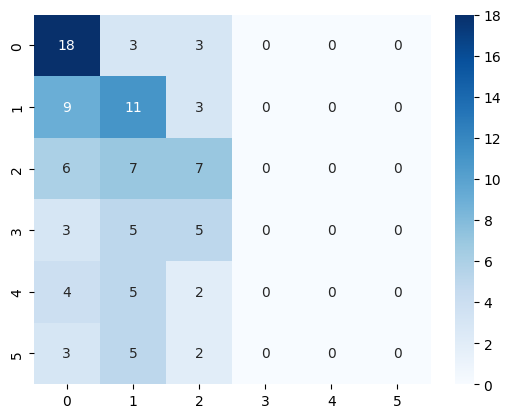

In [15]:
ax = sns.heatmap(confusion_matrix(y_test_final, topics_test), annot=True, fmt='d', cmap='Blues')